# Feature Expansion & Splines (Polynomial bases)

We capture curvature using polynomial features and, where available, splines on temperature.

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import TimeSeriesSplit

!wget -q https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Regression_Forecasting/reg_for_utils.py
import reg_for_utils as utils
csv_path = "https://raw.githubusercontent.com/Jihun-ust/ust-mail-557/main/Regression_Forecasting/marketing_daily.csv"

df = pd.read_csv(csv_path, parse_dates=["date"]).sort_values("date")
train, test = utils.time_train_test_split(df, "date", test_days=90)

features_base = ["search_spend","social_spend","display_spend","promo","price_index","temp_F","rain","is_weekend"]
target = "revenue"
X_train, y_train = train[features_base], train[target]
X_test, y_test = test[features_base], test[target]

try:
    from sklearn.preprocessing import SplineTransformer
    spline_ok = True
except Exception:
    spline_ok = False

numeric_poly = ["search_spend","social_spend","display_spend","price_index"]
cat = ["promo","rain","is_weekend"]

pre_poly = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler()), ("poly", PolynomialFeatures(degree=2, include_bias=False))]), numeric_poly),
    ("temp", "passthrough", ["temp_F"]),
    ("cat", OneHotEncoder(drop="if_binary"), cat)
])

if spline_ok:
    pre_spline = ColumnTransformer([
        ("num", StandardScaler(), ["search_spend","social_spend","display_spend","price_index"]),
        ("temp_spline", SplineTransformer(n_knots=6, degree=3), ["temp_F"]),
        ("cat", OneHotEncoder(drop="if_binary"), cat)
    ])

tscv = TimeSeriesSplit(n_splits=5)

poly_model = Pipeline([("pre", pre_poly), ("est", RidgeCV(alphas=np.logspace(-3,3,20), cv=tscv))])
poly_model.fit(X_train, y_train)
rmse_poly = utils.rmse(y_test, poly_model.predict(X_test))

if spline_ok:
    spline_model = Pipeline([("pre", pre_spline), ("est", RidgeCV(alphas=np.logspace(-3,3,20), cv=tscv))])
    spline_model.fit(X_train, y_train)
    rmse_spline = utils.rmse(y_test, spline_model.predict(X_test))
    print("RMSE (poly):", rmse_poly, " | RMSE (splines):", rmse_spline)
else:
    print("RMSE (poly):", rmse_poly, " | SplineTransformer not available in this environment.")

zsh:1: command not found: wget
RMSE (poly): 140.82062502028396  | RMSE (splines): 138.22670036683414


/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-p

## Partial dependence-style visualization (one variable at a time)
We hold others near their median to see curvature.

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


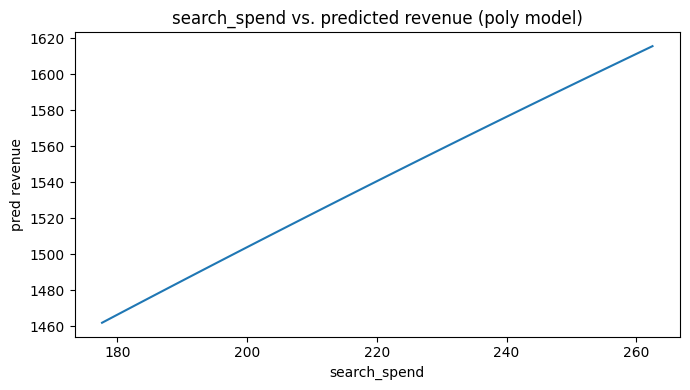

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


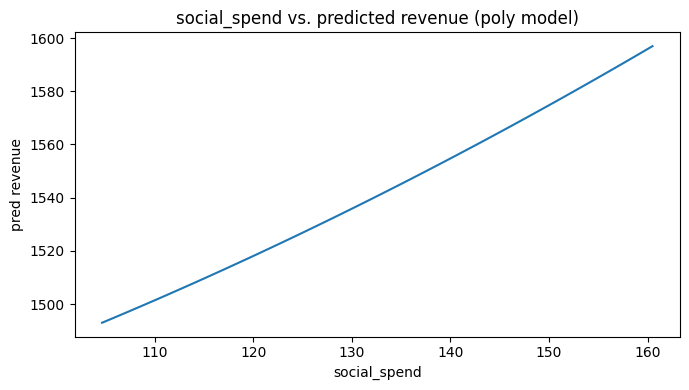

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


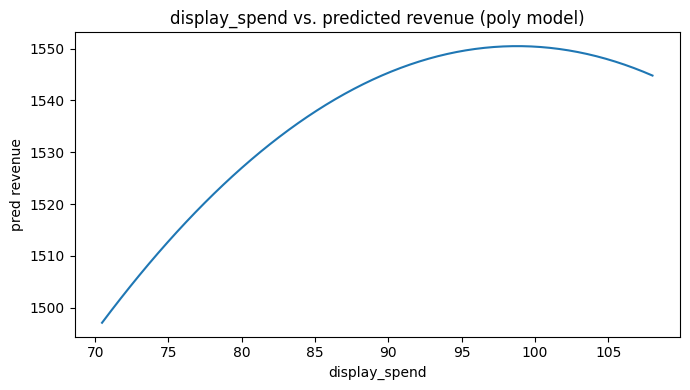

/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/jihunmoon/PythonProjects/Git/ust-mail/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


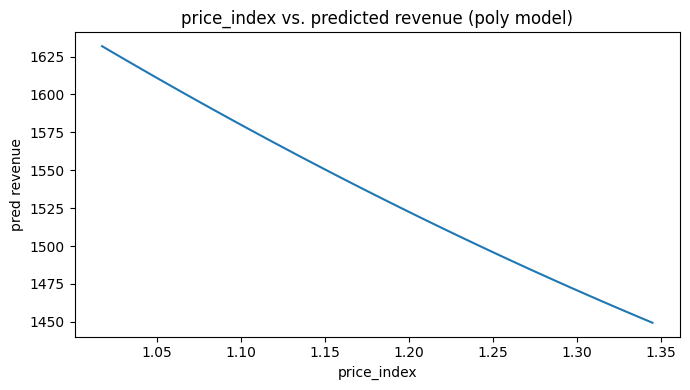

In [23]:
for selected_feature in numeric_poly:
    grid = np.linspace(df[selected_feature].quantile(0.05), df[selected_feature].quantile(0.95), 60)
    x0 = X_train.median(numeric_only=True).to_dict()
    rows = []
    for g in grid:
        row = x0.copy()
        row[selected_feature] = g
        row["promo"] = 0
        row["rain"] = 0
        row["is_weekend"] = 0
        rows.append(row)
    Xg = pd.DataFrame(rows)
    yg = poly_model.predict(Xg)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4))
    plt.plot(grid, yg)
    plt.title(selected_feature + " vs. predicted revenue (poly model)"); plt.xlabel(selected_feature); plt.ylabel("pred revenue")
    plt.tight_layout(); plt.show()